In [7]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

local_path = '/Users/juniorcedrictonga/Documents/pgm/Score-matching-project-'
sys.path.append(local_path)

%load_ext autoreload
%autoreload 2

import dataset
from dataset import sampling, densities, scores, visualisation
import score_matching
from score_matching import toy_models, learning_objectives, score_visualisation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data creation

### GMM

In [8]:
# Parameters
N = 10000
mus = [np.array([0, 0]), np.array([10,10])]
sigmas = [np.eye(2), np.eye(2)]
alphas = [0.5, 0.5]

# Dataset
gmm_data, clusters = sampling.gaussian_mixture_sampling(mus, sigmas, alphas, N)

### Banana shaped

In [9]:
# Parameters
N = 10000
mu_banana = np.array([0, 0])
sigma_banana = np.eye(2)

# Dataset
banana_data = sampling.banana_shaped_sampling(N, mu_banana, sigma_banana)

## Noise Conditional Score Networks

In [10]:
# Parameters

learning_rate = 1e-3
num_epochs = 1000

sigma_begin = 1 
sigma_end = 0.01
num_classes = 10 # number of sigmas to generate, in the paper it's represent as L 

## vector of num_classes of sigmas to use for data pertubation 
sigma_list = torch.tensor(np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), num_classes))).float() 


# Our approximation model
model = toy_models.ConditionalModel(num_classes)
model

ConditionalModel(
  (lin1): ConditionalLinear(
    (lin): Linear(in_features=2, out_features=128, bias=True)
    (embed): Embedding(10, 128)
  )
  (lin2): ConditionalLinear(
    (lin): Linear(in_features=128, out_features=128, bias=True)
    (embed): Embedding(10, 128)
  )
  (lin3): Linear(in_features=128, out_features=2, bias=True)
)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ScoreMatching = learning_objectives.ScoreMatching(optimizer, 'anneal_denoising_score_matching', device, sigma = sigma_list) # sigmas here is for data's pertubation 

- ### GMM

In [12]:
ScoreMatching.train(gmm_data, model, num_epochs, verbose=False, plot=False)

100%|██████████| 1000/1000 [00:18<00:00, 54.50it/s]

Training finished!


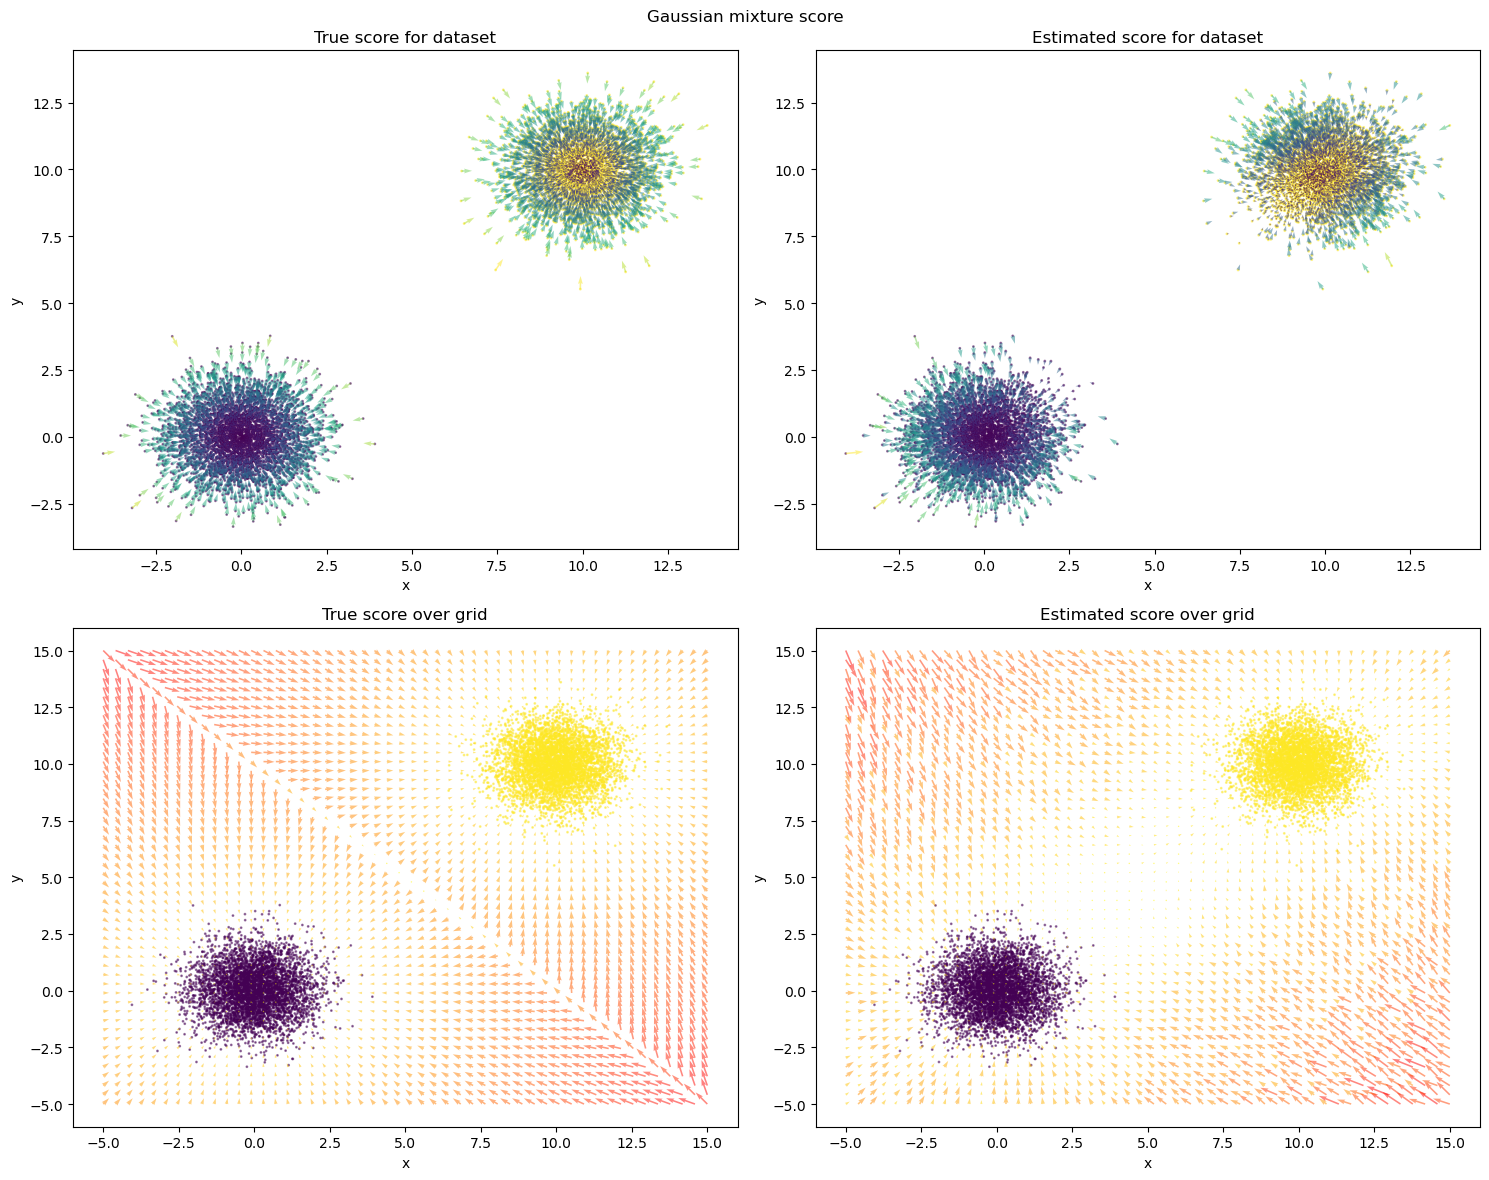

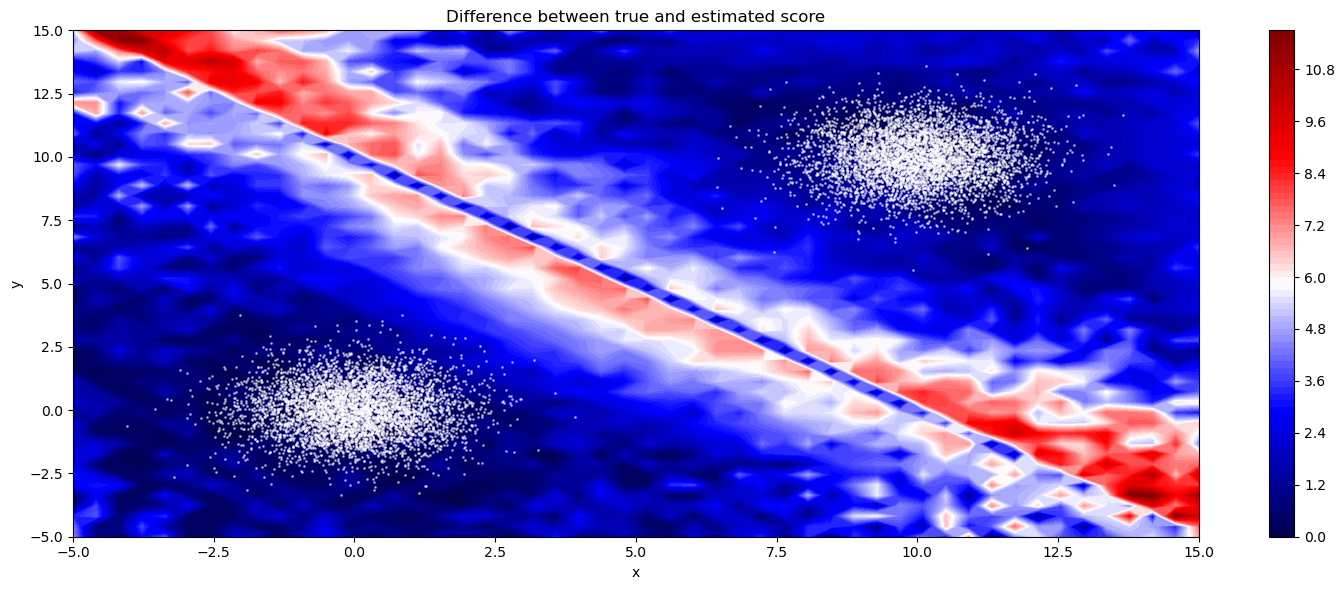

In [13]:
score_visualisation.plot_estimated_score_gmm(gmm_data, clusters, model, mus, sigmas, alphas, difference=True, type='anneal_denoising_score_matching',sigma_list=sigma_list)

- ### Banana-shaped data

In [14]:
ScoreMatching.train(banana_data,  model, num_epochs, verbose=False, plot=False)

100%|██████████| 1000/1000 [00:19<00:00, 52.60it/s]

Training finished!


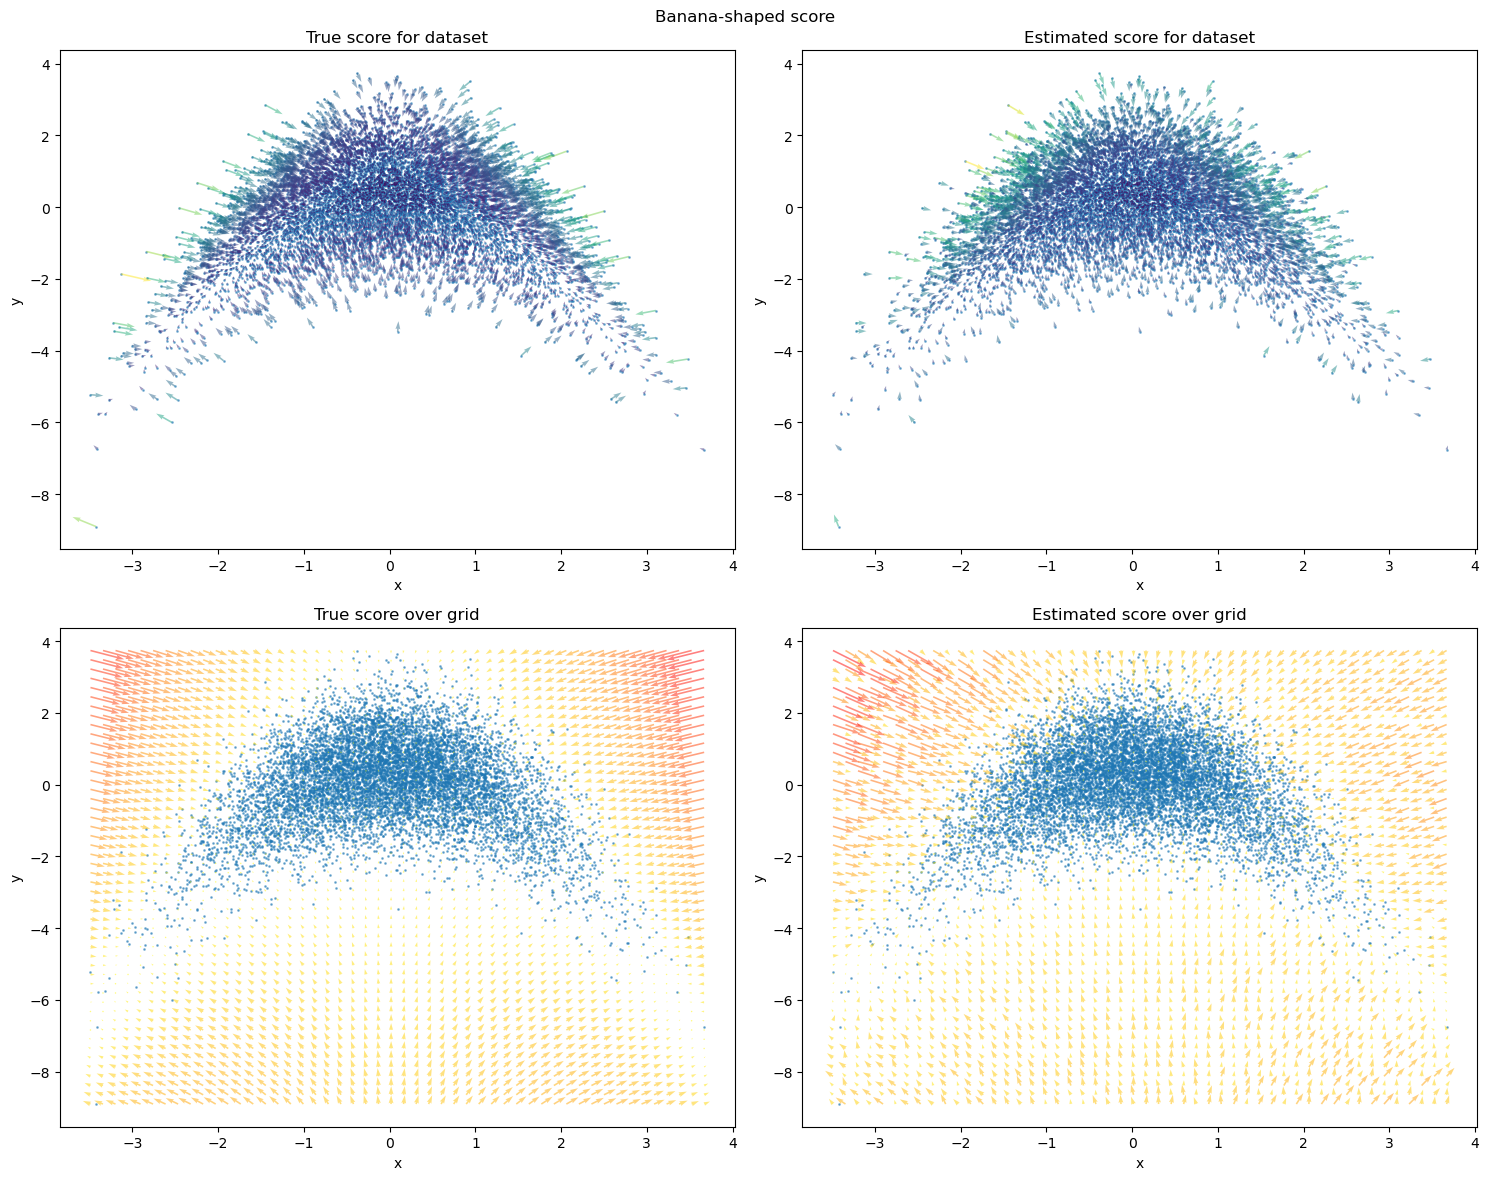

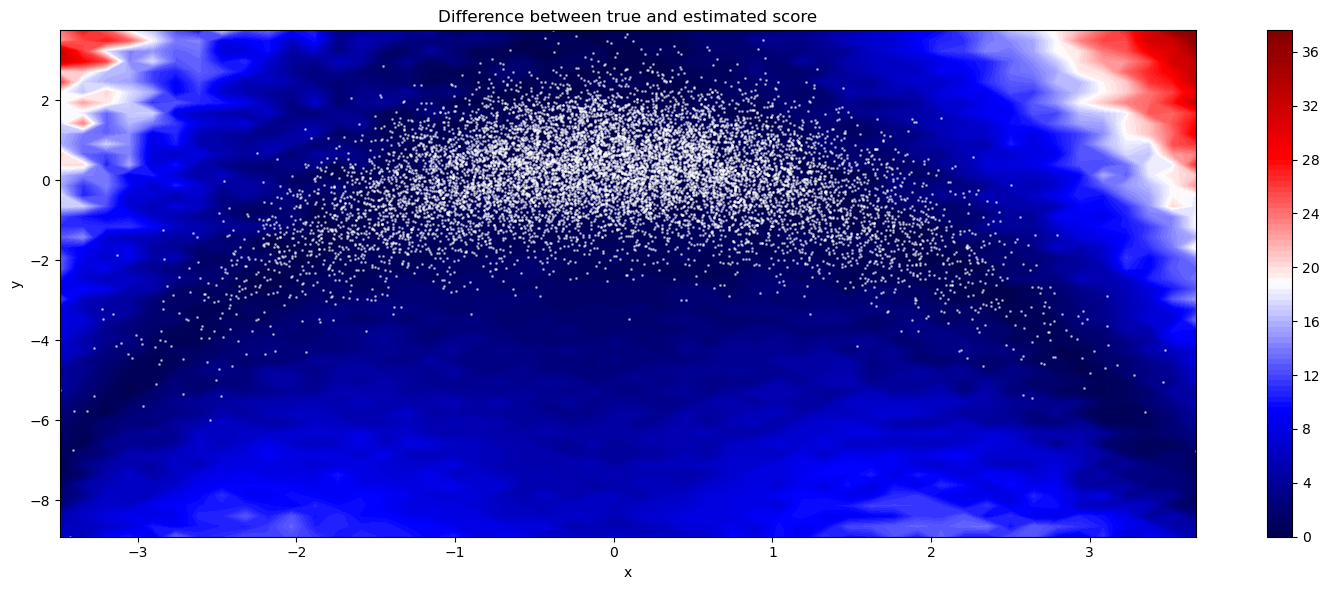

In [15]:
score_visualisation.plot_estimated_score_banana(banana_data, model, mu_banana, sigma_banana, difference=True, type='anneal_denoising_score_matching',sigma_list=sigma_list)